Initialise  
Mid price - classification rather than, 
Label - neural network (Random Forest)
mid-price

In [13]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Import data

In [14]:
data = pd.read_csv('UoB_Set01_2025-01-31LOBs.csv')
print(data.head())

       Time        Bid1        Bid2         Ask1         Ask2  Mid-Price  \
0  07:30:00      [0, 0]      [0, 0]       [0, 0]       [0, 0]       0.00   
1  07:30:01  [325.0, 1]      [0, 0]       [0, 0]       [0, 0]     162.50   
2  07:30:02  [325.0, 4]  [292.0, 2]  [724.38, 8]  [800.0, 15]     524.69   
3  07:30:03  [325.0, 1]  [292.0, 1]   [713.0, 1]   [800.0, 5]     519.00   
4  07:30:04  [325.0, 1]  [292.0, 1]   [713.0, 1]   [800.0, 5]     519.00   

   Total_volume  Bid_ask_spread  Order_imbalance  
0             0            0.00             0.00  
1             1         -325.00             1.00  
2            29          399.38            -0.59  
3             8          388.00            -0.50  
4             8          388.00            -0.50  


Split the data 80:20 by time

In [15]:
# Calculate the split index
split_index = int(len(data) * 0.8)

# Split the DataFrame into train and test sets based on the split index
train = data.iloc[:split_index]
test = data.iloc[split_index:]

Do ADF Test to check if data is stationary 

In [16]:
from statsmodels.tsa.stattools import adfuller
# Assuming `data` is a pandas Series of your time series data
result = adfuller(data['Order_imbalance'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if result[0] < result[4]["5%"]:
    print("Reject the null hypothesis - Data is stationary")
else:
    print("Fail to reject the null hypothesis - Data is not stationary")

ADF Statistic: -44.943939
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis - Data is stationary


Plot ACF

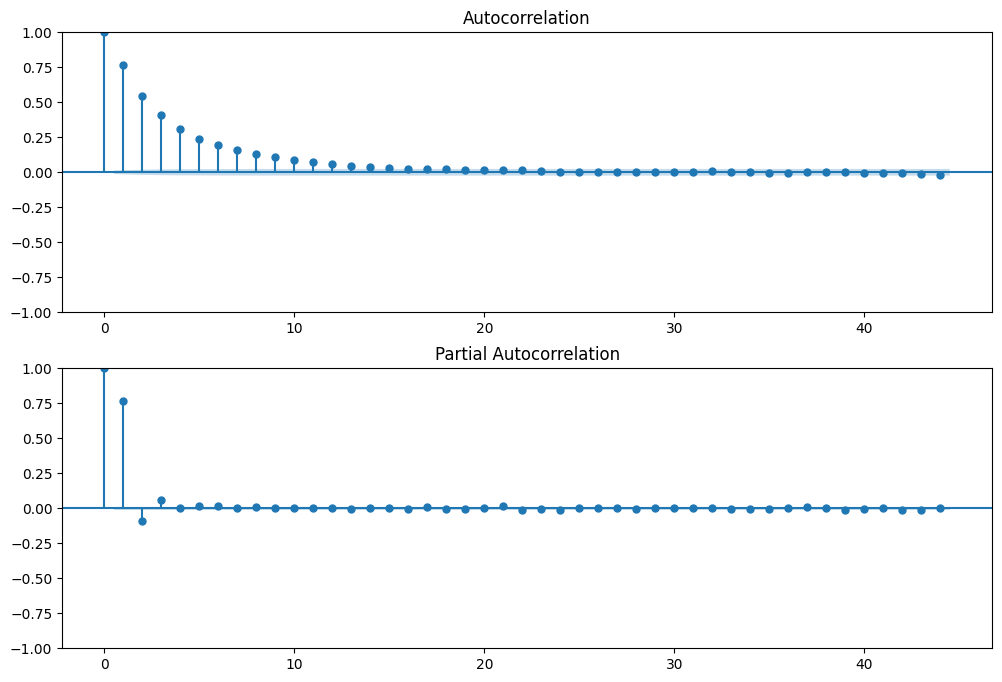

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Selecting the 'Mid-Price' column for ACF and PACF plots
train_mid_price = train['Order_imbalance']

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(train_mid_price, ax=ax[0])  # ACF plot for 'Mid-Price'
plot_pacf(train_mid_price, ax=ax[1])  # PACF plot for 'Mid-Price'

plt.show()

Order Imbalance Spread ACF and PACF Plot interpretation


ACF Plot Interpretation:

The ACF plot has a slow delay, suggesting a q of 0.

PACF Plot Interpretation:

The PACF plot shows a sharp cut-off after the first lag, which suggests that an AR term of order 1 might be appropriate. Therefore, p could be 1.

Differencing Term (d):

Data is stationary so d should be 0.

Do ARIMA

In [18]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model
model = ARIMA(train['Order_imbalance'], order=(1, 0, 0))  # Example order, adjust as necessary
model_fit = model.fit()
# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        Order_imbalance   No. Observations:                24479
Model:                 ARIMA(1, 0, 0)   Log Likelihood                4812.065
Date:                Mon, 19 Feb 2024   AIC                          -9618.130
Time:                        09:43:41   BIC                          -9593.814
Sample:                             0   HQIC                         -9610.252
                              - 24479                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1285      0.005     23.381      0.000       0.118       0.139
ar.L1          0.7628      0.005    166.170      0.000       0.754       0.772
sigma2         0.0395      0.000    126.090      0.0

Forecast the test set


In [19]:
# Forecast the length of the test values
arima_predicted = model_fit.forecast(steps=len(test))
predicted = arima_predicted.to_frame(name='Order_imbalance')

predicted.insert(0, 'Time', test['Time'])

print(type(predicted))
print(predicted)

<class 'pandas.core.frame.DataFrame'>
           Time  Order_imbalance
24479  14:18:00         0.221182
24480  14:18:01         0.199199
24481  14:18:02         0.182429
24482  14:18:03         0.169637
24483  14:18:04         0.159879
...         ...              ...
30594  15:59:55         0.128494
30595  15:59:56         0.128494
30596  15:59:57         0.128494
30597  15:59:58         0.128494
30598  15:59:59         0.128494

[6120 rows x 2 columns]


Plot the predicted against the test

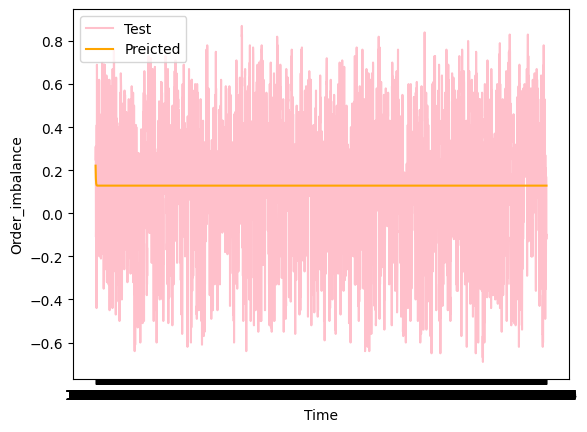

In [20]:
#plt.plot(train['Time'], train['Mid-Price'], label = 'Train')
plt.plot(test['Time'], test['Order_imbalance'], color = 'pink', label = 'Test')
plt.plot(predicted['Time'], predicted['Order_imbalance'], color = 'orange', label = 'Preicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Order_imbalance')
plt.show()

Error Measurements

In [21]:
# Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['Order_imbalance'], predicted['Order_imbalance'])
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['Order_imbalance'], predicted['Order_imbalance'])
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error
rmse = mean_squared_error(test['Order_imbalance'], predicted['Order_imbalance'], squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# R-squared
from sklearn.metrics import r2_score
r2 = r2_score(test['Order_imbalance'], predicted['Order_imbalance'])
print("R-squared:", r2)

Mean Absolute Error (MAE): 0.25091702845736447
Mean Squared Error (MSE): 0.09287302332327547
Root Mean Squared Error (RMSE): 0.30475075606678237
R-squared: -0.0004446408154714643


c:\Users\timot\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
